In [1]:
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms
import torch
import os
from more_itertools import peekable
import matplotlib.pyplot as plt


cwd = os.getcwd()
print(torch.cuda.is_available())
print("Current working directory:", cwd)

True
Current working directory: /sise/home/amitfoye/code_files/DL_A2


# Load The Dataset

### Paths

In [2]:
dataset_path = os.path.join(cwd, "lfw")
images_path = os.path.join(dataset_path, "lfw-deepfunneled", "lfw-deepfunneled")

match_dev_test_path = os.path.join(dataset_path, "matchpairsDevTest.csv")
match_dev_train_path = os.path.join(dataset_path, "matchpairsDevTrain.csv")
match_dev_val_path = os.path.join(dataset_path, "matchpairsDevVal.csv")

mismatch_dev_test_path = os.path.join(dataset_path, "mismatchpairsDevTest.csv")
mismatch_dev_train_path = os.path.join(dataset_path, "mismatchpairsDevTrain.csv")
mismatch_dev_val_path = os.path.join(dataset_path, "mismatchpairsDevVal.csv")


## Load The Data

In [3]:
match_dev_test_df = pd.read_csv(match_dev_test_path).sort_index()
match_dev_train_df = pd.read_csv(match_dev_train_path).sort_index()
mismatch_dev_test_df = pd.read_csv(mismatch_dev_test_path).sort_index()
mismatch_dev_train_df = pd.read_csv(mismatch_dev_train_path).sort_index()


### Split Into Validation Set

In [4]:
match_dev_train_df, match_dev_val_df = train_test_split(
    match_dev_train_df, test_size=0.2, random_state=42
)
mismatch_dev_train_df, mismatch_dev_val_df = train_test_split(
    mismatch_dev_train_df, test_size=0.2, random_state=42
)

match_dev_train_df = match_dev_train_df.reset_index(drop=True)
match_dev_val_df = match_dev_val_df.reset_index(drop=True)
mismatch_dev_train_df = mismatch_dev_train_df.reset_index(drop=True)
mismatch_dev_val_df = mismatch_dev_val_df.reset_index(drop=True)

In [5]:
match_dev_train_df['name1'] = match_dev_train_df['name']
match_dev_train_df['name2'] = match_dev_train_df['name']
match_dev_train_df = match_dev_train_df[['name1', 'imagenum1', 'name2', 'imagenum2']]
match_dev_train_df['label'] = 1

match_dev_val_df['name1'] = match_dev_val_df['name']
match_dev_val_df['name2'] = match_dev_val_df['name']
match_dev_val_df = match_dev_val_df[['name1', 'imagenum1', 'name2', 'imagenum2']]
match_dev_val_df['label'] = 1

match_dev_test_df['name1'] = match_dev_test_df['name']
match_dev_test_df['name2'] = match_dev_test_df['name']
match_dev_test_df = match_dev_test_df[['name1', 'imagenum1', 'name2', 'imagenum2']]
match_dev_test_df['label'] = 1

mismatch_dev_test_df['label'] = 0
mismatch_dev_train_df['label'] = 0
mismatch_dev_val_df['label'] = 0

train_df = pd.concat([match_dev_train_df, mismatch_dev_train_df], ignore_index=True).sample(frac=1).reset_index(drop=True)
val_df = pd.concat([match_dev_val_df, mismatch_dev_val_df], ignore_index=True).sample(frac=1).reset_index(drop=True)


### Loading The Images

In [7]:
# Create a dictionary to store the images
images_memo = {}

In [8]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to black and white
    transforms.Resize((250, 250)),               # Resize to match model input
    transforms.ToTensor()                        # Converts to tensor and scales to [0, 1]
])

def load_mismatch_images(person1, image_num1, person2, image_num2):
    def _extract_image(person, image_num):
        image_path = os.path.join(images_path, person, f"{person}_{image_num:04d}.jpg")
        image = Image.open(image_path)
        transformed = transform(image)
        images_memo[person, image_num] = transformed
        
        
    if (person1, image_num1) not in images_memo:
        _extract_image(person1, image_num1)
    if (person2, image_num2) not in images_memo:
        _extract_image(person2, image_num2)
    return images_memo[(person1, image_num1)], images_memo[(person2, image_num2)]





def load_match_images(person, image1, image2):
    return load_mismatch_images(person, image1, person, image2)

In [9]:
def make_minibatches(df, batch_size):
    """
    Create minibatches from the dataframe.
    """
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i + batch_size]
        images1 = []
        images2 = []
        labels = []
        
        for _, row in batch_df.iterrows():
            image1, image2 = load_mismatch_images(row['name1'], row['imagenum1'], row['name2'], row['imagenum2'])
            images1.append(image1)
            images2.append(image2)
            labels.append(row['label'])
        
        # Convert lists to tensors and yield them as a tuple
        yield torch.stack(images1), torch.stack(images2), torch.tensor(labels).reshape(-1, 1).float()

## Initializing The Network

In [10]:
class SiameseCNN(nn.Module):
    def __init__(self):
        super(SiameseCNN, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),     #(1, 250, 250) → (64, 241, 241)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                      #(64, 120, 120)

            nn.Conv2d(64, 128, kernel_size=7),    #(128, 114, 114)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                      #(128, 57, 57)

            nn.Conv2d(128, 128, kernel_size=4),   #(128,54, 54)
            nn.ReLU(),
            nn.MaxPool2d(2),                      #(128, 27, 27)

            nn.Conv2d(128, 256, kernel_size=4),   #(256, 24, 24)
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, X):
        return self.cnn(X)
    
    


class TwinsCNN(nn.Module):
    def __init__(self):
        super(TwinsCNN, self).__init__()
        
        # Share the same SiameseCNN instance for both branches
        self.scnn1 = SiameseCNN()
        self.scnn2 = self.scnn1  # Use the same SiameseCNN instance for shared weights

        self.fc = nn.Sequential(
            nn.Linear(256 * 24 * 24, 1),
            nn.Sigmoid()  # As used in the original paper
        )
        
    def forward(self, X1, X2):
        out1 = self.scnn1(X1)
        out2 = self.scnn2(X2)  # Same weights are used here due to reference
        out = torch.abs(out1 - out2)
        out = out.view(out.size(0), -1)
        return self.fc(out)
    
    def predict(self, X1, X2):
        out1 = self.scnn1(X1)
        out2 = self.scnn2(X2)  # Same weights are used here due to reference
        out = torch.abs(out1 - out2)
        out = out.view(out.size(0), -1)
        return torch.sigmoid(out)


## Training Method

In [46]:
def l2_regularization(model, lambda_l2=0.01):
    l2_loss = 0.0
    for param in model.parameters():
        l2_loss += torch.sum(param ** 2)  # L2 regularization (sum of squared parameters)
    return (lambda_l2 * l2_loss).reshape(1)  # Reshape to match the loss function output


def train(model, train_df, val_df, loss_fn, optimizer, device, l2_lambda=0.01, epochs=10, batch_size=32):
    model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []

    train_loader = peekable(make_minibatches(train_df.sample(frac=1).reset_index(drop=True), batch_size))
    val_loader = peekable(make_minibatches(val_df.sample(frac=1).reset_index(drop=True), batch_size))
    
    for epoch in range(epochs):
        model.train()  # set to training mode
        train_loss = 0
        num_batches = 0
        
        if(train_loader.peek(None) is None):
            train_loader = peekable(make_minibatches(train_df.sample(frac=1).reset_index(drop=True), batch_size))
        for inputs1, inputs2, targets in train_loader:  # inputs1 and inputs2 are the image pairs
            inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
            num_batches += 1
            optimizer.zero_grad()               
            outputs = model(inputs1, inputs2)  # Pass both inputs (image pairs) to the model
            loss = loss_fn(outputs, targets)
            cost = l2_regularization(model, l2_lambda)
            total_loss = loss + cost
            total_loss.backward()                     
            optimizer.step()                    

            train_loss += loss.item()
        avg_train_loss = train_loss / num_batches
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        num_batches = 0
        with torch.no_grad():
            if(val_loader.peek(None) is None):
                val_loader = peekable(make_minibatches(val_df.sample(frac=1).reset_index(drop=True), batch_size))
            for inputs1, inputs2, targets in val_loader:
                inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
                num_batches += 1
                outputs = model(inputs1, inputs2)
                loss = loss_fn(outputs, targets)
                cost = l2_regularization(model, l2_lambda)
                total_loss = loss + cost
                val_loss += total_loss.item()

                predicted = (outputs > 0.5)
                total += targets.shape[0]
                correct += predicted.eq(targets).sum().item()

        if (num_batches == 0):
            val_loader = make_minibatches(val_df, batch_size)
            continue
        avg_val_loss = val_loss / num_batches
        accuracy = 100. * correct / total
        val_accuracies.append(accuracy)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Val Loss: {avg_val_loss:.4f} "
              f"Val Accuracy: {accuracy:.2f}%")

    return train_losses, val_losses, val_accuracies


## Actual Training

In [ ]:
model = TwinsCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
train_losses, val_losses, val_accuracies = train(
    model,
    train_df,
    val_df,
    loss_fn,
    optimizer,
    device,
    l2_lambda=0.01,
    epochs=100
)

Epoch 1/500 Train Loss: 0.6900 Val Loss: 0.7742 Val Accuracy: 59.09%
Epoch 2/500 Train Loss: 0.6845 Val Loss: 0.7226 Val Accuracy: 59.77%
Epoch 3/500 Train Loss: 0.6738 Val Loss: 0.7296 Val Accuracy: 55.91%
Epoch 4/500 Train Loss: 0.6696 Val Loss: 0.7119 Val Accuracy: 62.05%
Epoch 5/500 Train Loss: 0.6539 Val Loss: 0.6775 Val Accuracy: 65.23%
Epoch 6/500 Train Loss: 0.6349 Val Loss: 0.7137 Val Accuracy: 60.00%
Epoch 7/500 Train Loss: 0.6233 Val Loss: 0.6460 Val Accuracy: 67.27%
Epoch 8/500 Train Loss: 0.6111 Val Loss: 0.6829 Val Accuracy: 67.95%
Epoch 9/500 Train Loss: 0.5883 Val Loss: 0.6912 Val Accuracy: 64.77%
Epoch 10/500 Train Loss: 0.5788 Val Loss: 0.6442 Val Accuracy: 70.91%
Epoch 11/500 Train Loss: 0.5603 Val Loss: 0.6240 Val Accuracy: 69.09%
Epoch 12/500 Train Loss: 0.5541 Val Loss: 0.6360 Val Accuracy: 69.32%
Epoch 13/500 Train Loss: 0.5359 Val Loss: 0.6341 Val Accuracy: 71.82%
Epoch 14/500 Train Loss: 0.5096 Val Loss: 0.6295 Val Accuracy: 67.73%
Epoch 15/500 Train Loss: 0.47

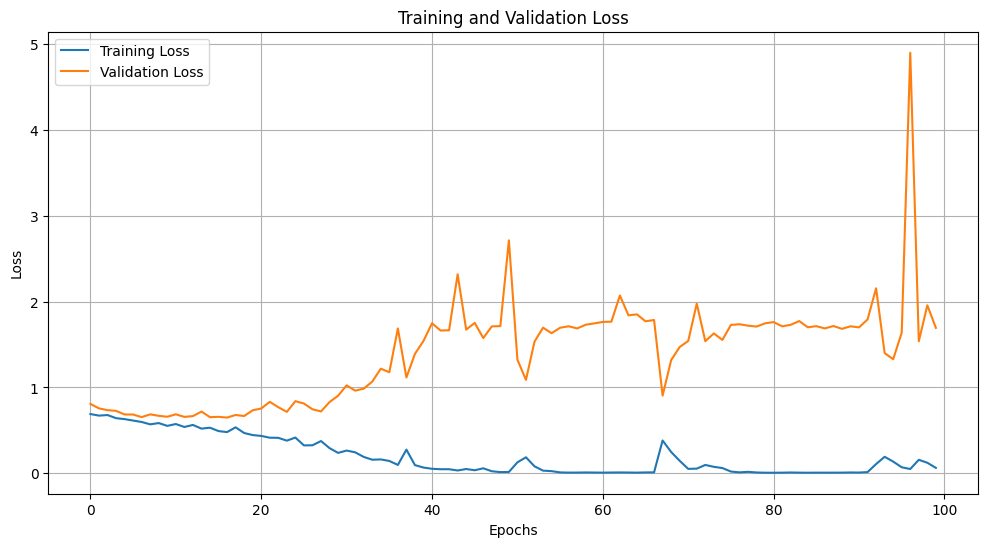

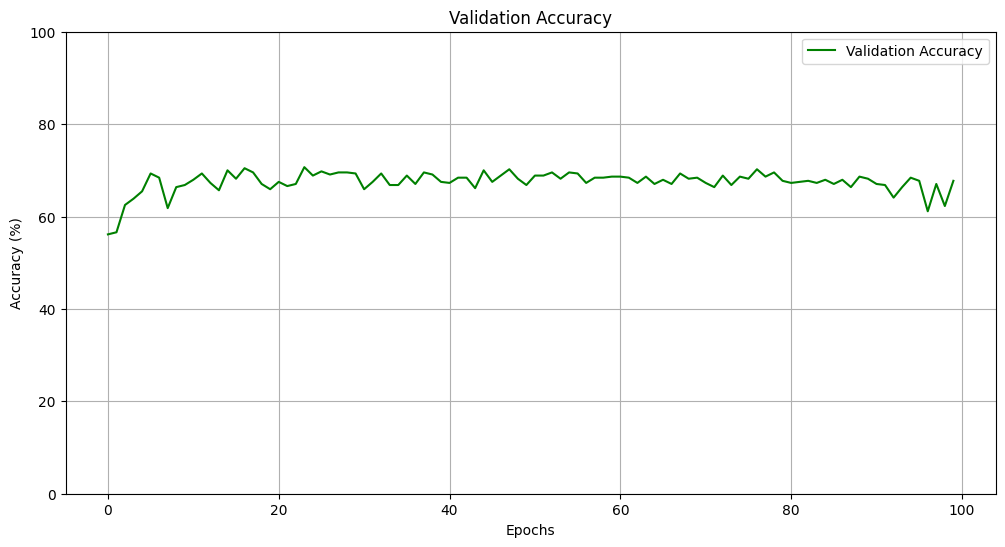

In [50]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.ylim(0, 100)  # Set y-axis range from 0 to 100
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# job_cancel_str="scancel " + os.environ['SLURM_JOBID']
# os.system(job_cancel_str)